In [66]:
#Installers
#---conda install -c conda-forge shap
#To install CatBoost from the conda-forge channel:

#Add conda-forge to your channels:
#---conda config --add channels conda-forge
#Install CatBoost:
#---conda install catboost
#Install visualization tools:
#Install the ipywidgets Python package (version 7.x or higher is required):

#---pip install ipywidgets
#Turn on the widgets extension:

#---jupyter nbextension enable --py widgetsnbextension

import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
import shap
from time import time

df_normalized = pd.read_csv('df_normalized.csv')
df_normalized = shuffle(df_normalized)
df_normalized.head()

,approval_amount,redeem_ts,contacted,email_contacted_ts,sms_contacted_ts,zip_code,rent_or_own,months_at_current_residence,years_at_current_residence,direct_deposit,...,source_INTERNET,source_KIOSK,source_MERCHANT,source_REMARKET,source_SHORT_CODE,source_SMS,source_SNAP_FINANCE_COM,initial_decision_APPROVED,initial_decision_APPROVED_WITH_CONDITIONS,initial_decision_DENIED
913,0.111028,1.0,0.0,1.0,1.0,0.287048,0.0,0.363636,0.041667,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,0.492710,1.0,0.0,1.0,1.0,0.100039,0.0,0.000000,0.125000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1618,0.222056,1.0,0.0,0.0,1.0,0.235576,0.0,0.000000,0.041667,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
783,0.225047,1.0,0.0,1.0,0.0,0.091436,0.0,0.000000,0.062500,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
892,0.072150,1.0,0.0,1.0,0.0,0.242197,1.0,0.000000,0.125000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
labels = df_normalized['redeem_ts']
features = df_normalized.drop(columns=['redeem_ts'])


# Probamos de nuevo con una MLP

In [68]:
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.35,random_state=13)

# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (3373, 1592)
3373 train samples
1817 test samples


In [69]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.optimizers import SGD
from keras.utils import np_utils


import timeit

# Needed to work with keras
#X_train = keras.utils.to_categorical(X_train,2)
#X_train = keras.utils.to_categorical(X_train,2)

y_train = keras.utils.to_categorical(y_train,2)
y_test = keras.utils.to_categorical(y_test,2)



In [74]:
# Building the model

model = Sequential()

model.add(Dense(128, input_dim=1592))  # 1592, 2, 2  input_shape=(1592, 2, 2)
#model.add(Dense(128, input_shape=(1592, 2, 2)))
model.add(Activation('relu'))
model.add(Dropout(.3)) # now using dropout
#model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(.2)) # now using dropout

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(.1)) # now using dropout

model.add(Dense(16))
model.add(Activation('tanh'))
model.add(Dropout(.1)) # now using dropout


model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(.1)) # now using dropout


model.add(Dense(2))
model.add(Activation('sigmoid'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               203904    
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_26 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
__________

## Entrenamiento MLP

In [76]:

start = timeit.default_timer()

model.fit(X_train, y_train, epochs=600, batch_size=200, verbose=0)

stop = timeit.default_timer()

score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

print('Time: ', stop - start) 

3373/3373 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step

 Training Accuracy: 0.9994070560332049
1817/1817 [==============================] - ETA:  - ETA:  - 0s 51us/step

 Testing Accuracy: 0.675288937612753
Time:  139.19098530001065


## Prueba de Catboost

In [7]:
df1 = pd.read_csv('proyectoF1T.csv')
df2 = pd.read_csv('proyectoF2F.csv')


df1 = df1.append(df2)
df2 = None    
print(df1.shape)

(6095, 31)


Eliminacion de columnas con base en analysis anterior

In [8]:
dfp = df1.drop(columns=['collections_category','amount_financed','last_payment_amount','black_listed','military_applicant','id','merchant_id'])
dfp.columns.shape

(24,)

In [9]:
dfp.isna().mean().round(4) 

approval_amount                0.0000
recommendation                 0.0000
redeem_ts                      0.5742
contacted                      0.0000
email_contacted_ts             0.0786
sms_contacted_ts               0.3993
birth_dt                       0.0000
state                          0.0000
city                           0.0003
zip_code                       0.0000
rent_or_own                    0.0000
months_at_current_residence    0.0000
years_at_current_residence     0.0000
direct_deposit                 0.0028
language_preference            0.0000
payment_frequency              0.0000
scheduled_payment_amt          0.0000
past_due_amt                   0.0000
account_payment_method         0.0000
days_past_due                  0.0000
number_of_payments             0.0000
data_correction                0.0000
source                         0.0000
initial_decision               0.0000
dtype: float64

In [10]:
dfp.loc[~dfp.email_contacted_ts.isnull(),"email_contacted_ts"]=True 
dfp.loc[~dfp.sms_contacted_ts.isnull(),"sms_contacted_ts"]=True 
dfp.loc[~dfp.direct_deposit.isnull(),"direct_deposit"]=True 
dfp.loc[~dfp.redeem_ts.isnull(),"redeem_ts"]=True 
dfp["email_contacted_ts"].fillna(False, inplace = True) 
dfp["sms_contacted_ts"].fillna(False, inplace = True)
dfp["direct_deposit"].fillna(False, inplace = True)
dfp["redeem_ts"].fillna(False, inplace = True) 
dfp.head()

,approval_amount,recommendation,redeem_ts,contacted,email_contacted_ts,sms_contacted_ts,birth_dt,state,city,zip_code,...,language_preference,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision
0,250.0,APPROVE,True,False,False,True,1988-05-21,CO,Aurora,80012,...,EN,WEEKLY,18.84,0.0,MANUAL,0,52,False,MERCHANT,APPROVED
1,80.0,APPROVE,True,False,True,False,1998-01-13,TX,Weatherford,76086,...,EN,BI_WEEKLY,32.88,0.0,MANUAL,0,26,False,INTERNET,APPROVED
2,956.0,APPROVE,True,False,True,True,1975-12-09,WA,Othello,99344,...,ES,MONTHLY,423.50,0.0,MANUAL,0,12,False,MERCHANT,APPROVED
3,9.0,APPROVE,True,False,False,True,1985-09-09,CA,Imperial,92251,...,EN,BI_WEEKLY,18.15,0.0,MANUAL,0,26,False,MERCHANT,APPROVED
4,250.0,APPROVE,True,False,True,True,1980-11-23,OH,Cleveland,44105,...,EN,BI_WEEKLY,87.73,0.0,MANUAL,0,26,False,MERCHANT,APPROVED


In [11]:
now = pd.Timestamp('now')
dfp['birth_dt'] = pd.to_datetime(dfp['birth_dt'])   
dfp['age'] = (now - dfp['birth_dt']).astype('<m8[Y]') 
dfp = dfp.drop(columns=['birth_dt'])
dfp.isna().mean().round(4) 


approval_amount                0.0000
recommendation                 0.0000
redeem_ts                      0.0000
contacted                      0.0000
email_contacted_ts             0.0000
sms_contacted_ts               0.0000
state                          0.0000
city                           0.0003
zip_code                       0.0000
rent_or_own                    0.0000
months_at_current_residence    0.0000
years_at_current_residence     0.0000
direct_deposit                 0.0000
language_preference            0.0000
payment_frequency              0.0000
scheduled_payment_amt          0.0000
past_due_amt                   0.0000
account_payment_method         0.0000
days_past_due                  0.0000
number_of_payments             0.0000
data_correction                0.0000
source                         0.0000
initial_decision               0.0000
age                            0.0000
dtype: float64

In [12]:
dfp = dfp.dropna()
dfp.shape

(6093, 24)

In [13]:
dfp.isna().mean().round(4) 

approval_amount                0.0
recommendation                 0.0
redeem_ts                      0.0
contacted                      0.0
email_contacted_ts             0.0
sms_contacted_ts               0.0
state                          0.0
city                           0.0
zip_code                       0.0
rent_or_own                    0.0
months_at_current_residence    0.0
years_at_current_residence     0.0
direct_deposit                 0.0
language_preference            0.0
payment_frequency              0.0
scheduled_payment_amt          0.0
past_due_amt                   0.0
account_payment_method         0.0
days_past_due                  0.0
number_of_payments             0.0
data_correction                0.0
source                         0.0
initial_decision               0.0
age                            0.0
dtype: float64

In [14]:
dfp['contacted']=dfp['contacted'].replace({False: 0, True :1})
dfp['email_contacted_ts']=dfp['email_contacted_ts'].replace({False: 0, True :1})
dfp['sms_contacted_ts']=dfp['sms_contacted_ts'].replace({False: 0, True :1})
dfp['rent_or_own']=dfp['rent_or_own'].replace({'RENT': 0, 'OWN' :1})
dfp['direct_deposit']=dfp['direct_deposit'].replace({False: 0, True :1})
dfp['language_preference']=dfp['language_preference'].replace({'EN': 0, 'ES' :1})
dfp['redeem_ts']=dfp['redeem_ts'].replace({False: 0, True :1})
dfp['data_correction']=dfp['data_correction'].replace({False: 0, True :1})

ind = 0
for i in dfp.columns:
    print(i + ' index # ', ind)
    ind += 1
    print(dfp[i].head())

dfp.head()

approval_amount index #  0
0    250.0
1     80.0
2    956.0
3      9.0
4    250.0
Name: approval_amount, dtype: float64
recommendation index #  1
0    APPROVE
1    APPROVE
2    APPROVE
3    APPROVE
4    APPROVE
Name: recommendation, dtype: object
redeem_ts index #  2
0    1
1    1
2    1
3    1
4    1
Name: redeem_ts, dtype: int64
contacted index #  3
0    0
1    0
2    0
3    0
4    0
Name: contacted, dtype: int64
email_contacted_ts index #  4
0    0
1    1
2    1
3    0
4    1
Name: email_contacted_ts, dtype: int64
sms_contacted_ts index #  5
0    1
1    0
2    1
3    1
4    1
Name: sms_contacted_ts, dtype: int64
state index #  6
0    CO
1    TX
2    WA
3    CA
4    OH
Name: state, dtype: object
city index #  7
0         Aurora
1    Weatherford
2        Othello
3       Imperial
4      Cleveland
Name: city, dtype: object
zip_code index #  8
0    80012
1    76086
2    99344
3    92251
4    44105
Name: zip_code, dtype: int64
rent_or_own index #  9
0    0
1    0
2    0
3    0
4    0
Name

,approval_amount,recommendation,redeem_ts,contacted,email_contacted_ts,sms_contacted_ts,state,city,zip_code,rent_or_own,...,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision,age
0,250.0,APPROVE,1,0,0,1,CO,Aurora,80012,0,...,WEEKLY,18.84,0.0,MANUAL,0,52,0,MERCHANT,APPROVED,31.0
1,80.0,APPROVE,1,0,1,0,TX,Weatherford,76086,0,...,BI_WEEKLY,32.88,0.0,MANUAL,0,26,0,INTERNET,APPROVED,21.0
2,956.0,APPROVE,1,0,1,1,WA,Othello,99344,0,...,MONTHLY,423.50,0.0,MANUAL,0,12,0,MERCHANT,APPROVED,43.0
3,9.0,APPROVE,1,0,0,1,CA,Imperial,92251,0,...,BI_WEEKLY,18.15,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,33.0
4,250.0,APPROVE,1,0,1,1,OH,Cleveland,44105,0,...,BI_WEEKLY,87.73,0.0,MANUAL,0,26,0,MERCHANT,APPROVED,38.0


## Feature importance

In [15]:

def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba(X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [16]:
def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
    model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

labels = dfp['redeem_ts']
features = dfp.drop(columns=['redeem_ts'])

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.35,random_state=13)


In [17]:
for col in X_train.columns:
    print(col, X_train[col].nunique())
    
X_train.head()    

approval_amount 1269
recommendation 2
contacted 2
email_contacted_ts 2
sms_contacted_ts 2
state 45
city 1305
zip_code 2334
rent_or_own 2
months_at_current_residence 13
years_at_current_residence 30
direct_deposit 2
language_preference 2
payment_frequency 5
scheduled_payment_amt 3450
past_due_amt 389
account_payment_method 3
days_past_due 121
number_of_payments 4
data_correction 2
source 6
initial_decision 3
age 68


,approval_amount,recommendation,contacted,email_contacted_ts,sms_contacted_ts,state,city,zip_code,rent_or_own,months_at_current_residence,...,payment_frequency,scheduled_payment_amt,past_due_amt,account_payment_method,days_past_due,number_of_payments,data_correction,source,initial_decision,age
1729,126.0,APPROVE,0,1,0,CA,San Fernando,91340,0,1,...,MONTHLY,31.68,0.00,MANUAL,0,12,0,MERCHANT,APPROVED,30.0
2342,429.0,APPROVE,0,1,0,CA,Santa Fe Springs,90670,0,0,...,WEEKLY,42.65,0.00,CARD,0,52,0,MERCHANT,APPROVED,25.0
2613,1076.0,APPROVE,0,1,1,TX,Whitney,76692,1,0,...,BI_WEEKLY,178.64,0.00,MANUAL,0,26,0,MERCHANT,APPROVED,36.0
1703,399.0,APPROVE,0,1,1,UT,Herriman,84096,1,4,...,BI_WEEKLY,61.82,0.00,MANUAL,0,26,0,SNAP_FINANCE_COM,APPROVED,34.0
1521,1470.0,APPROVE,0,1,1,TX,Cypress,77433,1,1,...,MONTHLY,486.58,1946.32,MANUAL,121,24,0,MERCHANT,APPROVED,35.0


In [18]:
categorical_features_indices = [1,5,6,8,12,13,16,20,21]

iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,1000,1600,1800,2000]
loss = []
for i in iteration:
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = i)
    model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
    )
    loss.append((i, log_loss(model, X_test, y_test), log_loss(model, X_train, y_train)))
    print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


<function matplotlib.pyplot.show(*args, **kw)>

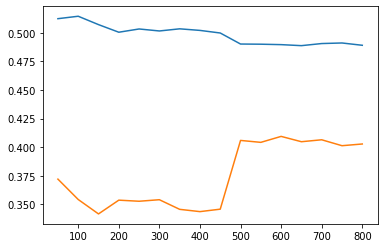

In [19]:
plt.plot([i[0] for i in loss],[i[1] for i in loss]) 
plt.plot([i[0] for i in loss],[i[2] for i in loss]) 
plt.show

In [20]:
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 600)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

## Feature importance with Shap values

In [21]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

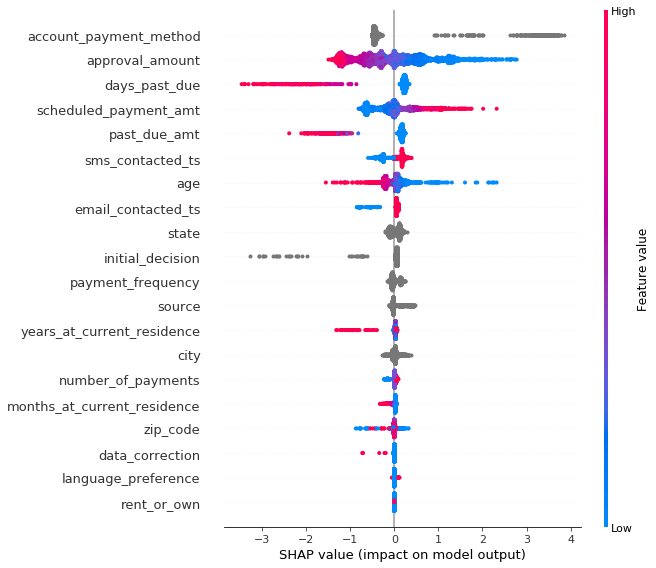

In [22]:
import time

start_time = time.time()
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test) 
elapsed = time.time() - start_time

In [23]:
elapsed


1.5429201126098633

In [24]:
timeit.default_timer()


622.4734191

In [25]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X_test, y_test, log_loss)
    
    elif method == "Baseline":
        fi = baseline_importance(model, X_train, y_train, X_test, y_test, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

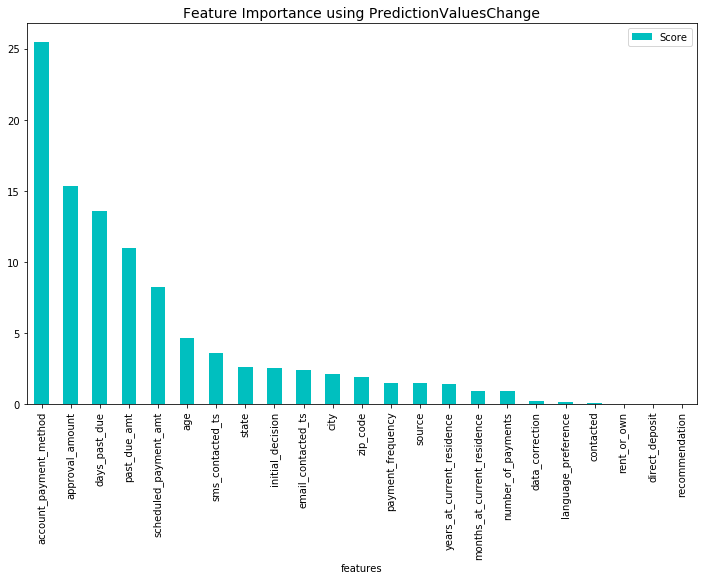

Wall time: 284 ms


In [26]:
%time get_feature_imp_plot(method="PredictionValuesChange")


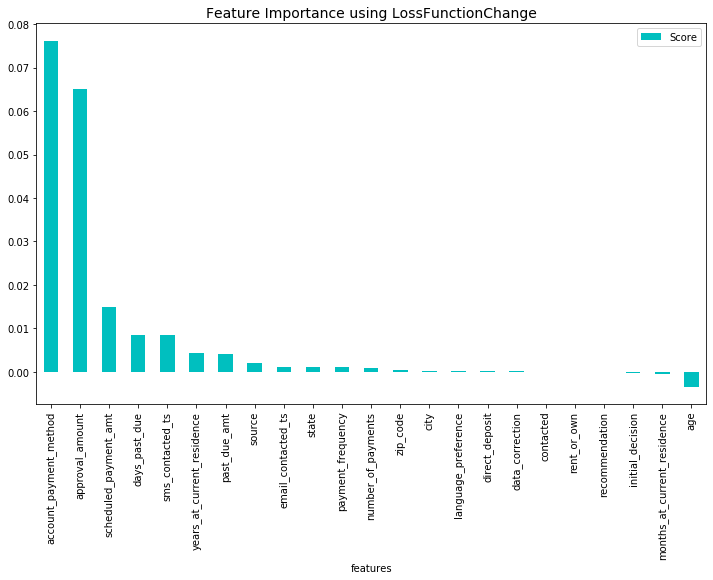

Wall time: 854 ms


In [27]:
%time get_feature_imp_plot(method="LossFunctionChange")


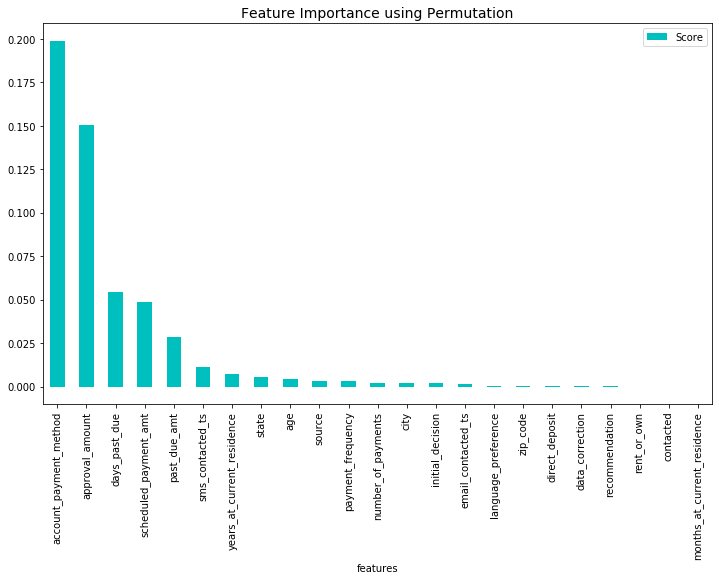

Wall time: 3.24 s


In [28]:
%time get_feature_imp_plot(method="Permutation")


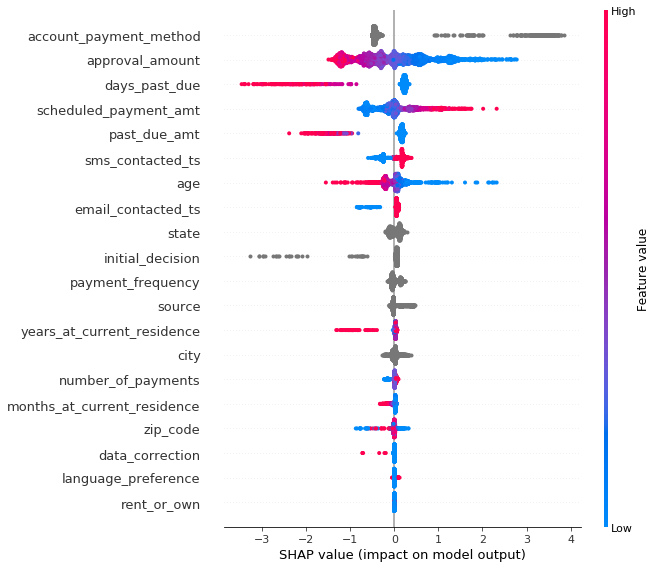

Wall time: 1.44 s


In [29]:
%time get_feature_imp_plot(method="ShapeValues")


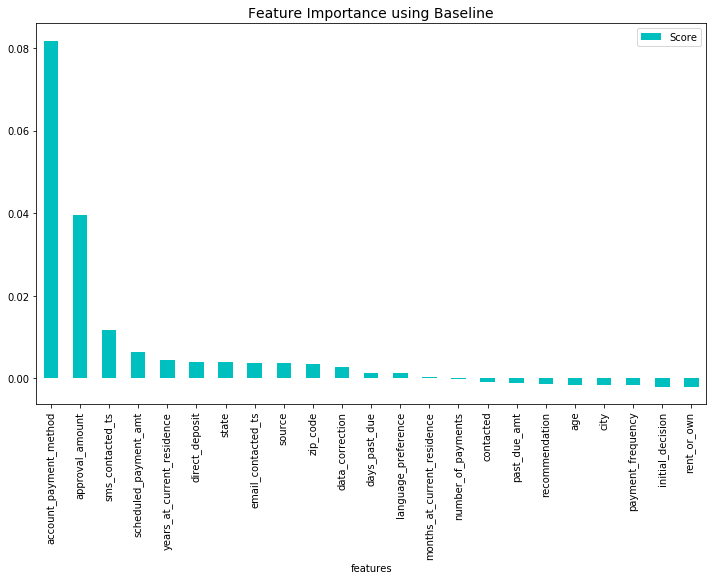

Wall time: 6min 50s


In [30]:
%time get_feature_imp_plot(method="Baseline")


## Interaction Feature importance

El siguiente analysis muestra cual es la interaccion entre features y su puntaje de interaccion

In [31]:
fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="Interaction")

In [32]:
fi[:5]

array([[ 0.        ,  5.        ,  6.1066258 ],
       [ 0.        , 14.        ,  5.00153944],
       [ 0.        , 22.        ,  3.68370037],
       [ 0.        , 17.        ,  3.29470098],
       [ 5.        , 14.        ,  3.07838719]])

In [33]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_test.dtypes.index[fi[k][0]]
    second = X_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "/" + second, fi[k][2]])

In [34]:
fi_new[:5]

[['approval_amount/state', 6.106625796990609],
 ['approval_amount/scheduled_payment_amt', 5.00153944216455],
 ['approval_amount/age', 3.683700369391792],
 ['approval_amount/days_past_due', 3.2947009758701187],
 ['state/scheduled_payment_amt', 3.078387185139755]]

In [35]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

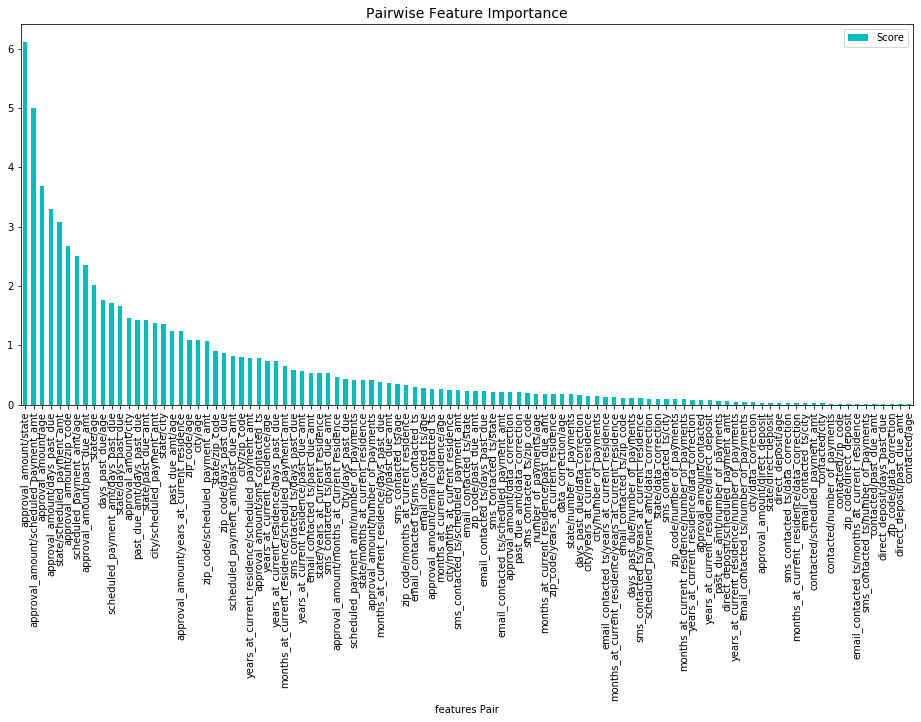

In [36]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

In [39]:
feature = 'account_payment_method'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

In [40]:
feature = 'approval_amount'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

In [41]:
feature = 'days_past_due'
res = model.calc_feature_statistics(X_train, y_train, feature, plot=True)

In [62]:
model2 = CatBoostClassifier(one_hot_max_size = 10, iterations = 2000)
model2.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    verbose = False,plot =True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
model3 = CatBoostClassifier(one_hot_max_size = 10, iterations = 15000,loss_function='MultiClass')
model3.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    verbose = False,plot =True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=5000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    loss_function='MultiClass',
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    verbose=False,
    cat_features = categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

(2595, 31)
(6095, 31)
(6095, 16)
(6095, 1)
(6095, 16)
(6095, 15)
(6095, 15)
(6095, 17)
(6095, 1)


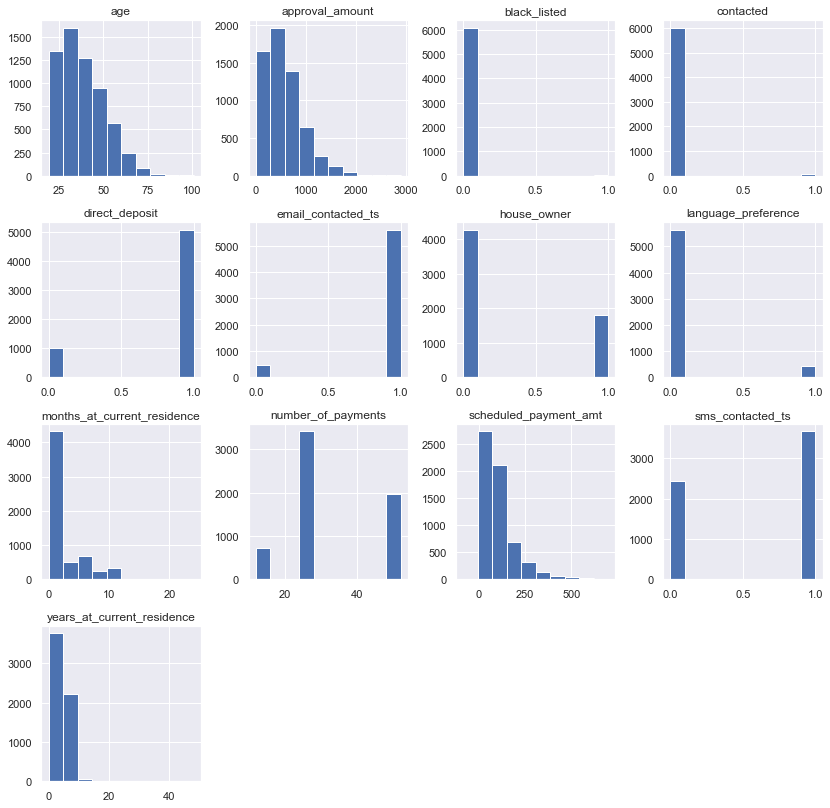

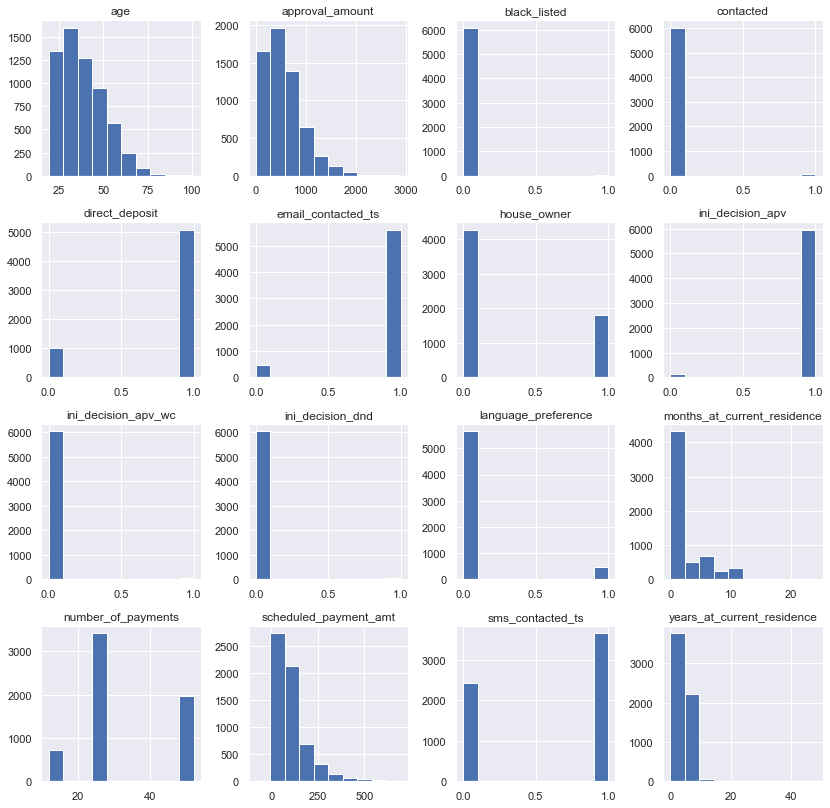

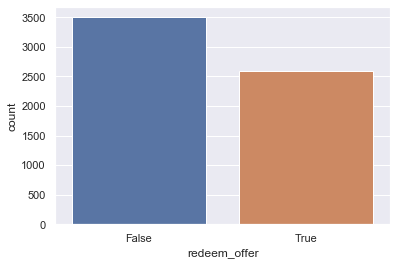

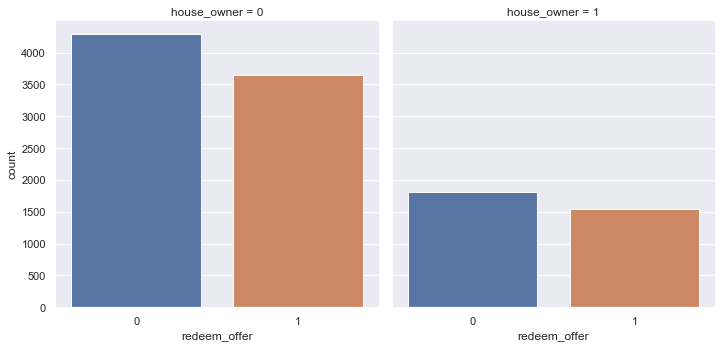

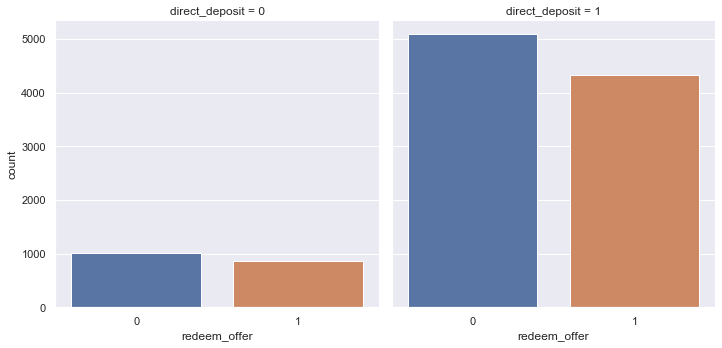

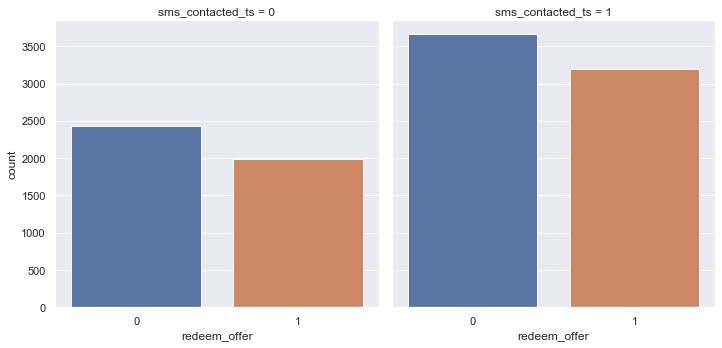

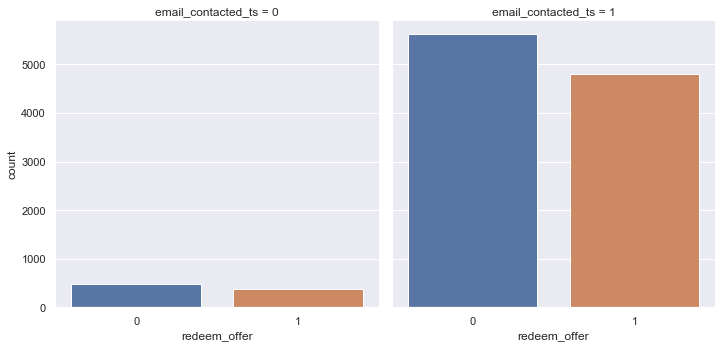

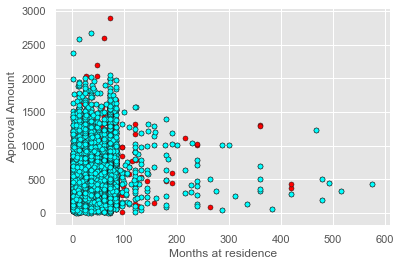


Prediction accuracy for the training dataset
46.89%

Prediction accuracy for the test dataset
48.26%

Accuracy on training set: 0.55
Accuracy on test set: 0.52
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1920      
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_11 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)        

NameError: name 'foo' is not defined

In [65]:
%run ./MLproyectoFinal.ipynb
foo()
